##### 线性回归(70)
Author: Wei Jiangnan 2024.9
##### 简介
本作业需要你实现采用`随机梯度下降`算法优化的`线性回归`，基于 'data.csv' 中给定的数据预测下一天的最高气温和最低气温（倒数第二行和倒数第一行）。算法的目标是迭代地更新 `w` 和 `b` 以优化模型。本次作业需要完整地完成从数据读取、预处理、训练、评估到可视化的整个流程。
##### 任务
1. 读取数据集，将数据集分为训练集和测试集。(10)
2. 训练模型，使用随机梯度下降算法优化线性回归模型。 (30)
3. 测试模型，计算测试集上的准确率。 (10)
4. 可视化训练过程中训练集和测试集上的loss。 (10)
5. 在测试集上任选一条数据，输出其预测值和真实值（无需实现，前几步算法正确的情况下预测值与真实值相近即可）。 (10)
##### 提示
1. **形状**  注意数据的形状，特别是矩阵的形状。你可以使用`x.shape`查看矩阵`m`的形状。
2. **预处理**  归一化有助于模型的收敛，你可以尝试不进行归一化，并查看训练效果。
3. **误差**  误差包括归一化前的误差和归一化后的误差，归一化前的误差具有物理意义，即温度的均方误差。
##### **注意:** 不要修改已经提供的代码。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

##### 归一化和反归一化

In [2]:
def normalize(data):
    '''
    Args:
        data: data to be normalized
    Returns:
        normalized data, mean, std
    '''
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean) / std, mean, std

In [3]:
def denormalize(data, mean, std):
    '''
    Args:   
        data: data to be denormalized
        mean: mean of the data
        std: std of the data    
    Returns:
        denormalized data
    '''
    return data * std + mean

##### 加载数据

In [4]:
def load_data(path):
    '''
    Args:
        path: 数据路径
    Returns:
        X_train: 训练集数据
        X_test: 测试集数据
        y_train_Tmax: 训练集Tmax标签
        y_test_Tmax: 测试集Tmax标签
        y_train_Tmin: 训练集Tmin标签
        y_test_Tmin: 测试集Tmin标签
        mean: 训练集数据的均值
        std: 训练集数据的标准差
    '''
    ## 从路径中读取数据
    data = pd.read_csv(path, sep=',', header=None)
    # 数据的第一行当成数据，格式是DataFrame
    # data=pd.read_csv(".\\data.csv",sep=',',header=None)
    ## 补全此处代码
    ## 删除data的缺失值(NaN)
    data=data.dropna()
    
    ## 删除data的前两列和第一行，相当于只要第一行且第三列以后的数据
    data=data.iloc[1:,2:]

    ## 将data转换为numpy数组,并将数据类型转换为float
    data=data.to_numpy().astype(float)

    ## 将data归一化,并保存每一列的mean和std
    data, mean, std=normalize(data)

    ## 将数据分为训练集和测试集,比例为3:1
    test_ratio = 0.25
    # 在range(len(data))的索引内，选择int(len(data)*test_ratio)个数，random.sample()随机选取test_ratio比例的数据作为测试集
    # 标记索引
    test_label=random.sample(range(len(data)),int(len(data)*test_ratio))
    # 集合求差
    train_label=list(set(range(len(data)))-set(test_label))
    test_data=data[test_label]
    train_data=data[train_label]
    ## 将数据分为X和y
    ## 本题中需要预测两个y，包括Tmax和Tmin
    X_train = train_data[:, :-2]
    X_test = test_data[:, :-2]
    y_train_Tmax = train_data[:, -2].reshape(-1, 1)# 行向量变成列向量
    y_test_Tmax = test_data[:, -2].reshape(-1, 1)
    y_train_Tmin = train_data[:, -1].reshape(-1, 1)
    y_test_Tmin = test_data[:, -1].reshape(-1, 1)
    return X_train, X_test, y_train_Tmax, y_test_Tmax, y_train_Tmin, y_test_Tmin, mean, std

##### 实现梯度下降的迭代器

In [5]:
def get_batch(X, y, batch_size):
    '''
    Args:
        X: 训练集数据
        y: 训练集标签
        batch_size: 批次大小
    Returns:
        一个批次的数据
    '''
    ## 生成一个批次的数据
    for index_now in range(0,len(X),batch_size):
        yield X[index_now:min(index_now+batch_size,len(X))],y[index_now:min(index_now+batch_size,len(X))]

In [6]:
X_train, X_test, y_train_Tmax, y_test_Tmax, y_train_Tmin, y_test_Tmin, mean,std = load_data('.\\data.csv')

##### 前向传播、计算损失和反向传播

In [7]:
def forward(X, w, b):
    '''
    Args:
        X: 输入数据
        w: 权重
        b: 偏置
    Returns:    
        y: 预测值
    '''
    ## 前向传播，也就是说用当前的w和b来计算y（预测下一天的值）
    ## 补全此处代码
    y=np.dot(X,w)+b
    return y

In [8]:
def loss(y_true, y_pred):
    '''
    Args:
        y_true: 真实值
        y_pred: 预测值
    Returns:
        均方误差损失
    '''
    ## 计算均方误差损失
    ## 补全此处代码
    loss=np.mean((y_true-y_pred)**2)
    return loss

In [9]:
def gradient(X, y_true, y_pred):
    '''
    Args:
        X: 输入数据
        y_true: 真实值
        y_pred: 预测值
    Returns:
        w的梯度, b的梯度
    '''
    ## 计算w,b的梯度
    ## 补全此处代码
    dw = -2 * np.dot(X.T, (y_true - y_pred)) / len(y_true)
    db = -2 * np.mean(y_true - y_pred)
    return dw, db
    

##### 训练

In [10]:
def train(X_train, y_train, X_test, y_test, batch_size, lr, epoches):
    '''
    Args:
        X_train: 训练集数据
        y_train: 训练集标签
        X_test: 测试集数据
        y_test: 测试集标签
        batch_size: 批次大小
        lr: 学习率
        epoches: 迭代次数
    Returns:
        best_w: 最优w
        best_b: 最优b
        train_losses: 训练集损失
        test_losses: 测试集损失
    '''
    ## 初始化参数，高斯分布(一开始的参数是随机的，有多少个样本就有多少个参数)
    w = np.random.normal(size=(X_train.shape[1], 1))
    b = 0
    ## 记录训练过程中的损失值
    train_losses = []
    test_losses = []
    ## 最优参数
    best_w = None
    best_b = None
    ## 训练
    for epoch in range(epoches):
        ## 随机梯度下降
        train_loss_sum = 0
        for X_batch, y_batch in get_batch(X_train, y_train, batch_size):
            ## 计算y_hat, dw, db（计算预测值）
            ## 补全此处代码
            y_hat=forward(X_batch,w,b)
            train_loss=loss(y_batch,y_hat)
            dw,db=gradient(X_batch,y_batch,y_hat)
            w -= lr * dw
            b -= lr * db
            ## 更新loss的和
            ## 补全此处代码，注意求平均是对于训练集样本数的平均
            train_loss_sum+=train_loss

        train_losses.append(train_loss_sum / (len(X_train)//batch_size+1))
        ## 计算测试集上的损失test_loss
        ## 补全此处代码
        y_pred=forward(X_test,w,b)
        test_loss=loss(y_test,y_pred)
        test_losses.append(test_loss)
        ## 输出训练过程中的loss
        print('epoch: {}, train loss: {}, test loss: {}'.format(epoch, train_losses[-1], test_losses[-1]))
        ## 记录最优的参数
        if epoch == 0 or test_loss < min(test_losses[:-1]):
            best_w = w[:,:]
            best_b = b
    return best_w, best_b, train_losses, test_losses

In [11]:
w_Tmax, b_Tmax, train_losses_Tmax, test_losses_Tmax = train(X_train, y_train_Tmax, X_test, y_test_Tmax, 300, 0.01, 50)

epoch: 0, train loss: 22.70463780023833, test loss: 13.49892739926008
epoch: 1, train loss: 10.862994215583102, test loss: 7.60326650818411
epoch: 2, train loss: 6.577779175905282, test loss: 4.937485940696483
epoch: 3, train loss: 4.462665761705448, test loss: 3.483243246188953
epoch: 4, train loss: 3.2388447452908147, test loss: 2.5949281721140434
epoch: 5, train loss: 2.4604419915304736, test loss: 2.0101827473388836
epoch: 6, train loss: 1.932986199945665, test loss: 1.6040691623405434
epoch: 7, train loss: 1.5585558225846448, test loss: 1.310360465696782
epoch: 8, train loss: 1.2830538855920302, test loss: 1.0912041594939261
epoch: 9, train loss: 1.0746004726230387, test loss: 0.9236829711692306
epoch: 10, train loss: 0.9134290604135082, test loss: 0.7932365541183192
epoch: 11, train loss: 0.7867292323975054, test loss: 0.690210630953323
epoch: 12, train loss: 0.6858576952237252, test loss: 0.6079544205412175
epoch: 13, train loss: 0.6047663183163192, test loss: 0.5417294224121891

In [12]:
w_Tmin, b_Tmin, train_losses_Tmin, test_losses_Tmin = train(X_train, y_train_Tmin, X_test, y_test_Tmin, 300, 0.01, 50)

epoch: 0, train loss: 5.774914585001764, test loss: 3.861910250526999
epoch: 1, train loss: 2.639816983786336, test loss: 2.138882501094996
epoch: 2, train loss: 1.5845109695107127, test loss: 1.3782341484368636
epoch: 3, train loss: 1.07930534668735, test loss: 0.978753746459449
epoch: 4, train loss: 0.799903620811216, test loss: 0.7471480772707254
epoch: 5, train loss: 0.6318027934649604, test loss: 0.6033304070792798
epoch: 6, train loss: 0.5243636716999333, test loss: 0.5089617203036149
epoch: 7, train loss: 0.4521426609371673, test loss: 0.4439576011984087
epoch: 8, train loss: 0.4013303304394138, test loss: 0.3971565329433206
epoch: 9, train loss: 0.36405143593715455, test loss: 0.3620903123225628
epoch: 10, train loss: 0.33565290229552786, test loss: 0.33488345336241426
epoch: 11, train loss: 0.31330328717168077, test loss: 0.3131432551280913
epoch: 12, train loss: 0.29523059599187956, test loss: 0.29534810901894976
epoch: 13, train loss: 0.28029315359243046, test loss: 0.280500

##### 输出结果

In [13]:
print('loss of Tmax: ', min(test_losses_Tmax), 'loss of Tmin: ', min(test_losses_Tmin))
print('MSE of Tmax in Celsius: ', min(test_losses_Tmax) * std[-2] ** 2, ', MSE of Tmin in Celsius: ', min(test_losses_Tmin) * std[-1] ** 2)

loss of Tmax:  0.231356912728765 loss of Tmin:  0.1720445039198609
MSE of Tmax in Celsius:  2.2400131522665405 , MSE of Tmin in Celsius:  1.059928408270574


##### 可视化

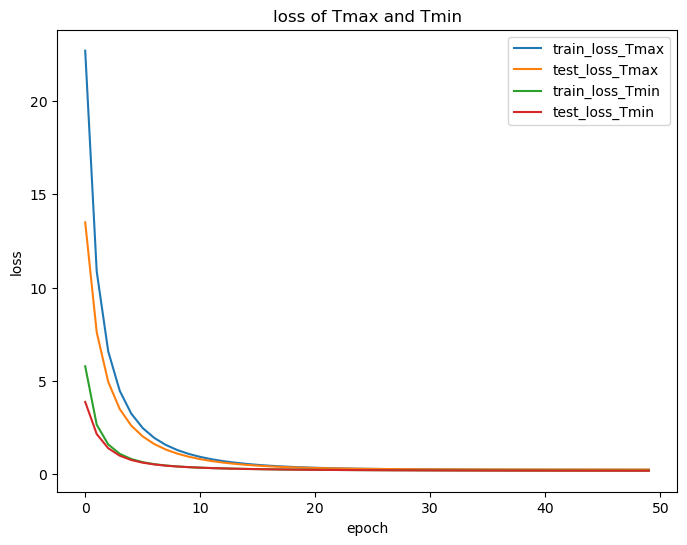

In [14]:
## 画出训练过程中的训练集和测试集上的loss变化曲线
## 补全此处代码
plt.figure(figsize=(8, 6))
plt.plot(train_losses_Tmax,label='train_loss_Tmax')
plt.plot(test_losses_Tmax,label='test_loss_Tmax')
plt.plot(train_losses_Tmin,label='train_loss_Tmin')
plt.plot(test_losses_Tmin,label='test_loss_Tmin')
plt.title('loss of Tmax and Tmin')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

##### 在测试集上任选一条数据，输出其预测值和真实值

In [15]:
## 预测归一化前的真实温度
def predict(X, w, b, Tmax=True):
    ## 补全此处代码,Tmax=True表示预测Tmax，否则预测Tmin
    # 反归一化
    y_pred = forward(X, w, b)
    if Tmax:
        return denormalize(y_pred, mean[-2], std[-2])
    else:
        return denormalize(y_pred, mean[-1], std[-1])



In [16]:
print('predict Tmax:',predict(X_test[0], w_Tmax, b_Tmax,True), 'true Tmax:',y_test_Tmax[0]*std[-2]+mean[-2])
print('predict Tmin:',predict(X_test[0], w_Tmin, b_Tmin,False), 'true Tmin:',y_test_Tmin[0]*std[-1]+mean[-1])

predict Tmax: [31.55763573] true Tmax: [28.6]
predict Tmin: [22.31686222] true Tmin: [23.4]


# 笔记
梯度下降是一种优化算法，广泛用于机器学习和深度学习模型的训练中。其主要目的是通过迭代地调整模型参数，最小化损失函数，从而提高模型的性能。

### 梯度下降算法的基本步骤：

1. **初始化参数**：随机初始化模型参数（例如线性回归中的权重和偏置）。

2. **计算损失**：使用当前参数计算损失函数的值。损失函数衡量模型预测值与真实值之间的差异。

3. **计算梯度**：计算损失函数相对于每个参数的梯度。梯度是损失函数在参数空间中的导数，指示了损失函数增加最快的方向。

4. **更新参数**：根据梯度更新参数。更新公式为：
   \[
   \theta = \theta - \alpha \cdot \nabla J(\theta)
   \]
   其中，\(\theta\) 是参数，\(\alpha\) 是学习率，\(\nabla J(\theta)\) 是损失函数的梯度。

5. **重复迭代**：重复步骤 2 到 4，直到损失函数收敛到一个最小值或达到预设的迭代次数。

### 梯度下降的变种：

- **批量梯度下降（Batch Gradient Descent）**：每次迭代使用整个训练集计算梯度，更新参数。
- **随机梯度下降（Stochastic Gradient Descent, SGD）**：每次迭代使用一个样本计算梯度，更新参数。
- **小批量梯度下降（Mini-batch Gradient Descent）**：每次迭代使用一个小批量样本计算梯度，更新参数。

### 梯度下降的优缺点：

- **优点**：
  - 简单易实现。
  - 适用于大规模数据集。

- **缺点**：
  - 选择合适的学习率较为困难。
  - 可能陷入局部最小值或鞍点。
  - 对于非凸函数，可能无法找到全局最小值。

### 应用场景：

梯度下降广泛应用于各种机器学习算法中，如线性回归、逻辑回归、神经网络等。在这些算法中，梯度下降用于优化模型参数，以最小化损失函数，从而提高模型的预测性能。